# Segmentation

# 1. U-Net

In [1]:
import numpy as np
import os, matplotlib, random
from matplotlib import pyplot as plt

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.utils import load_img, img_to_array

In [2]:
import tensorflow as tf
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 1.1. Data Loading

In [3]:
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
!tar -xf images.tar.gz
!tar -xf annotations.tar.gz

--2023-08-10 05:50:40--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz [following]
--2023-08-10 05:50:40--  https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz [following]
--2023-08-10 05:50:40--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 301 Moved Perman

In [4]:
input_dir = "images/"
target_dir = "annotations/trimaps/"

input_img_paths = sorted(
    [os.path.join(input_dir, fname)
     for fname in os.listdir(input_dir)
     if fname.endswith(".jpg")])
target_paths = sorted(
    [os.path.join(target_dir, fname)
     for fname in os.listdir(target_dir)
     if fname.endswith(".png") and not fname.startswith(".")])

print(len(input_img_paths), input_img_paths)
print(len(target_paths), target_paths)

input_img_paths = input_img_paths[:1000] # 데이터 1000개만 사용
target_paths = target_paths[:1000]

print(len(input_img_paths), len(target_paths))

7390 ['images/Abyssinian_1.jpg', 'images/Abyssinian_10.jpg', 'images/Abyssinian_100.jpg', 'images/Abyssinian_101.jpg', 'images/Abyssinian_102.jpg', 'images/Abyssinian_103.jpg', 'images/Abyssinian_104.jpg', 'images/Abyssinian_105.jpg', 'images/Abyssinian_106.jpg', 'images/Abyssinian_107.jpg', 'images/Abyssinian_108.jpg', 'images/Abyssinian_109.jpg', 'images/Abyssinian_11.jpg', 'images/Abyssinian_110.jpg', 'images/Abyssinian_111.jpg', 'images/Abyssinian_112.jpg', 'images/Abyssinian_113.jpg', 'images/Abyssinian_114.jpg', 'images/Abyssinian_115.jpg', 'images/Abyssinian_116.jpg', 'images/Abyssinian_117.jpg', 'images/Abyssinian_118.jpg', 'images/Abyssinian_119.jpg', 'images/Abyssinian_12.jpg', 'images/Abyssinian_120.jpg', 'images/Abyssinian_121.jpg', 'images/Abyssinian_122.jpg', 'images/Abyssinian_123.jpg', 'images/Abyssinian_124.jpg', 'images/Abyssinian_125.jpg', 'images/Abyssinian_126.jpg', 'images/Abyssinian_127.jpg', 'images/Abyssinian_128.jpg', 'images/Abyssinian_129.jpg', 'images/Abyss

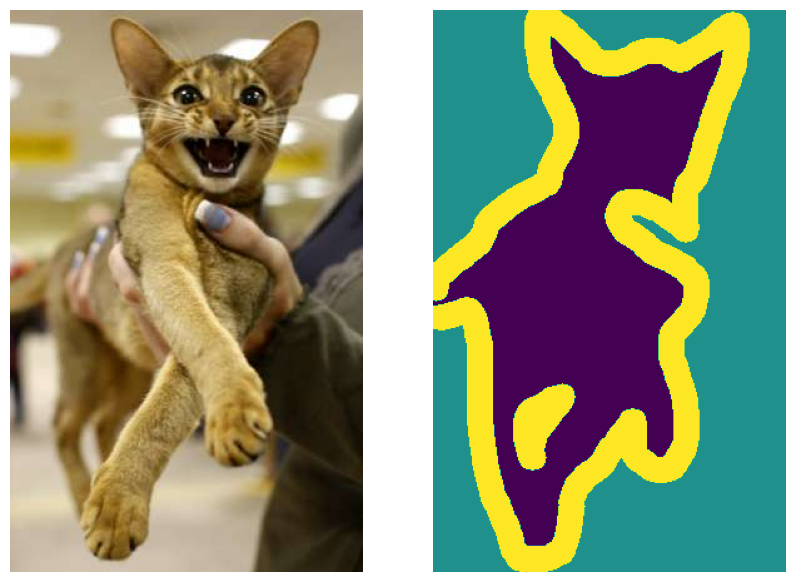

In [6]:
imgn = 11

def display_target(target_array):
    normalized_array = (target_array.astype("uint8") - 1) * 127 # label 값은 1,2,3 -> 0,1,2
    return normalized_array[:, :, 0]

img = img_to_array(load_img(target_paths[imgn], color_mode="grayscale"))

plt.figure(figsize=(10,8))
plt.subplot(121)
plt.axis("off")
plt.imshow(load_img(input_img_paths[imgn]))
plt.subplot(122)
plt.axis("off")
plt.imshow(display_target(img))

### 1.2. Data Pre-processing

In [7]:
img_size = (256, 256) # 이미지 사이즈 정규화
num_imgs = len(input_img_paths)

# 데이터 셔플링
random.Random(1337).shuffle(input_img_paths) # 이미지 셔플링
random.Random(1337).shuffle(target_paths) # 타겟 셔플링

# 이미지를 array로 변환
def path_to_input_image(path):
    return img_to_array(load_img(path, target_size=img_size))

# 레이블 이미지를 마스크(1, 0) 이미지로 변환
def path_to_target(path):
    img = img_to_array(
        load_img(path, target_size=img_size, color_mode="grayscale"))
    img = img.astype("uint8") - 1
    return img

input_imgs = np.zeros((num_imgs,) + img_size + (3,), dtype="float32") # 이미지는 RBG 3채널
targets = np.zeros((num_imgs,) + img_size + (1,), dtype="uint8")
for i in range(num_imgs):
    input_imgs[i] = path_to_input_image(input_img_paths[i])
    targets[i] = path_to_target(target_paths[i])

# 검증 데이터셋 분할
num_val_samples = 200 # 검증 데이터셋에는 200건 사용
train_input_imgs = input_imgs[:-num_val_samples]
train_targets = targets[:-num_val_samples]
val_input_imgs = input_imgs[-num_val_samples:]
val_targets = targets[-num_val_samples:]

In [8]:
print(train_input_imgs.shape)
print(val_targets.shape)

(800, 256, 256, 3)
(200, 256, 256, 1)


## 1.3. Model Build

In [12]:
class UNet:
    def __init__(self, params):
        self.input_size = params['input_size']
        self.conv_act = params['conv_act']
        self.output_num = params['output_num']
        self.output_act = params['output_act']
    def __call__(self, model_name):
        if model_name == "UNet":
            inputs = Input(shape=self.input_size, name='input_layer')
            # Encoder
            cblock1 = self.conv_block(inputs, 1, 2, 32, 3, self.conv_act)
            pool1 = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pool%s' %(1))(cblock1)
            cblock2 = self.conv_block(pool1, 2, 2, 64, 3, self.conv_act)
            pool2 = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pool%s' %(2))(cblock2)
            cblock3 = self.conv_block(pool2, 3, 2, 128, 3, self.conv_act)
            pool3 = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pool%s' %(3))(cblock3)
            cblock4 = self.conv_block(pool3, 4, 2, 256, 3, self.conv_act)
            pool4 = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pool%s' %(4))(cblock4)
            cblock5 = self.conv_block(pool4, 5, 2, 512, 3, self.conv_act)
            pool5 = layers.MaxPooling2D(pool_size=(2, 2), strides=2, name='max_pool%s' %(5))(cblock5)
            # Bottleneck
            bottleneck = self.conv_block(pool5, 4, 2, 1024, 3, self.conv_act, bottle=True)
            # Decoder
            up1 = layers.Conv2DTranspose(512, 2, strides=2, name='conv_trans%s' %(1))(bottleneck)
            ublock1 = self.up_block(up1, cblock5, 1, 2, 512, 3, self.conv_act)
            up2 = layers.Conv2DTranspose(256, 2, strides=2, name='conv_trans%s' %(2))(ublock1)
            ublock2 = self.up_block(up2, cblock4, 2, 2, 256, 3, self.conv_act)
            up3 = layers.Conv2DTranspose(128, 2, strides=2, name='conv_trans%s' %(3))(ublock2)
            ublock3 = self.up_block(up3, cblock3, 3, 2, 128, 3, self.conv_act)
            up4 = layers.Conv2DTranspose(64, 2, strides=2, name='conv_trans%s' %(4))(ublock3)
            ublock4 = self.up_block(up4, cblock2, 4, 2, 64, 3, self.conv_act)
            up5 = layers.Conv2DTranspose(32, 2, strides=2, name='conv_trans%s' %(5))(ublock4)
            ublock5 = self.up_block(up5, cblock1, 5, 2, 32, 3, self.conv_act)
            outputs = layers.Conv2D(self.output_num, 1, padding='same', activation=self.output_act, name='output_layer')(ublock5)
            model = Model(inputs=inputs, outputs=outputs)
            return model
    def conv_block(self,
                   lr_conv, # input layer
                   bk_num:int, # block number
                   lr_num:int, # convolution number
                   filters:int, # filter number
                   kern_size:int, # kernel size
                   activ:str, # activation
                   reg_weight=None, # kernel regularizer
                   bottle:bool=False
                   ):
        # code
        for i in range(lr_num):
            lr_conv = layers.Conv2D(filters, kern_size, activation=None, padding='same',
                                        name=f'conv_block{bk_num}-conv{i+1}' if bottle == False else f'bottleneck-conv{i+1}',
                                        kernel_regularizer=reg_weight, kernel_initializer='he_normal')(lr_conv)
            lr_conv = layers.BatchNormalization(name=f'conv_block{bk_num}-batch_norm{i+1}' if bottle == False else f'bottleneck-batch_norm{i+1}')(lr_conv)
            lr_conv = layers.Activation(activ, name=f'conv_block{bk_num}-activ{i+1}' if bottle == False else f'bottleneck-activ{i+1}')(lr_conv)
        return lr_conv

    def up_block(self,
                 input_up, # up input
                 input_skip, # skip input
                 bk_num:int, # block number
                 lr_num:int, # convolution number
                 filters:int, # filters
                 kern_size:int, # kernel size
                 activ:str, # activation
                 reg_weight:str=None # kernel regularizer
                 ):
        # code
        lr_conc = layers.Concatenate(name='up_block%s-concatenate' %(bk_num))([input_skip, input_up])
        for i in range(lr_num):
            if i == 0:
                conv_in = lr_conc
            else:
                conv_in = lr_conv
            lr_conv = layers.Conv2D(filters, kern_size, activation=None, padding='same',
                                        name='up_block%s-upsample%s' %(bk_num, i+1),
                                        kernel_regularizer=reg_weight, kernel_initializer='he_normal')(conv_in)
            lr_conv = layers.BatchNormalization(name='up_block%s-batch_norm%s' %(bk_num, i+1))(lr_conv)
            lr_conv = layers.Activation(activ, name='up_block%s-activ%s' %(bk_num, i+1))(lr_conv)
        return lr_conv

In [14]:
unet_param = {'input_size': (256,256,3),
              'conv_act': 'relu',
              'output_num': 3,
              'output_act': 'softmax'}

unet = UNet(unet_param)
model = unet('UNet')
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv_block1-conv1 (Conv2D)     (None, 256, 256, 32  896         ['input_layer[0][0]']            
                                )                                                                 
                                                                                                  
 conv_block1-batch_norm1 (Batch  (None, 256, 256, 32  128        ['conv_block1-conv1[0][0]']      
 Normalization)                 )                                                             

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    x = layers.Rescaling(1./255)(inputs) # 이미지 정규화 (0~1)

    x1 = layers.Conv2D(64, 3, name='conv1_1', strides=2, activation="relu", padding="same")(x)
    x1 = layers.Conv2D(64, 3, name='conv1_2', activation="relu", padding="same")(x1)
    x2 = layers.Conv2D(128, 3, name='conv2_1', strides=2, activation="relu", padding="same")(x1)
    x2 = layers.Conv2D(128, 3, name='conv2_2', activation="relu", padding="same")(x2)
    x3 = layers.Conv2D(256, 3, name='conv3_1', strides=2, padding="same", activation="relu")(x2)
    x3 = layers.Conv2D(256, 3, name='conv3_2', activation="relu", padding="same")(x3)

    y3 = layers.Conv2DTranspose(256, 3, name='up3_1', activation="relu", padding="same")(x3)
    y3 = layers.Conv2DTranspose(256, 3, name='up3_2', activation="relu", padding="same", strides=2)(y3)
    y2 = layers.Concatenate(name='concat_2')([x2, y3])
    y2 = layers.Conv2DTranspose(128, 3, name='up2_1', activation="relu", padding="same")(y2)
    y2 = layers.Conv2DTranspose(128, 3, name='up2_2', activation="relu", padding="same", strides=2)(y2)
    y1 = layers.Concatenate(name='concat_1')([x1, y2])
    y1 = layers.Conv2DTranspose(64, 3, name='up1_1', activation="relu", padding="same")(y1)
    y1 = layers.Conv2DTranspose(64, 3, name='up1_2', activation="relu", padding="same", strides=2)(y1)

    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(y1) # 최종 클래스 3개

    model = keras.Model(inputs, outputs)
    return model

model = get_model(img_size=img_size, num_classes=3)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_2 (Rescaling)        (None, 256, 256, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_1 (Conv2D)               (None, 128, 128, 64  1792        ['rescaling_2[0][0]']            
                                )                                                                 
                                                                                            

### 1.4. Model Training

In [ ]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.keras",
                                    save_best_only=True)
]

history = model.fit(train_input_imgs, train_targets,
                    epochs=50,
                    callbacks=callbacks,
                    batch_size=64,
                    validation_data=(val_input_imgs, val_targets))